In [1]:
# Dependencies
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress
import seaborn as sns
from scipy import stats

In [2]:
csv_path = "Resources/videos.csv"
df = pd.read_csv(csv_path)
# df.head(10)

In [3]:
# clean up data before creating dataframe for calculations
df_path = "Resources/videos.csv"
df = pd.read_csv(df_path)

df[["publish date", "asdf"]] = df["publish_time"].str.split(pat="T", n=1, expand=True)


df[["publish time", "trash"]] = df["asdf"].str.split(pat=".", n=1, expand=True)


df["publish date"] = pd.to_datetime(df["publish date"])
df["publish_date"] = df["publish date"].dt.strftime('%m/%d/%Y')


category_json_path = "Resources/US_category_id.json"
category_dict = {'category_id': [], 'Category': []}
indexer = 0

with open(category_json_path) as json_data:
  data = json.load(json_data)

items = data['items']
# items

for item in items:
    
    category_dict['category_id'].append(data['items'][indexer]['id'])
    category_dict['Category'].append(data['items'][indexer]['snippet']['title'])
    indexer = indexer + 1
        


category_df = pd.DataFrame(category_dict)
category_df["category_id"] = category_df["category_id"].astype(int)
df = df.merge(category_df, how='inner', on='category_id')



df["trending_date"]=pd.to_datetime(df["trending_date"].astype(str), format="%y.%d.%m")
df["trending_date"] = df["trending_date"].dt.strftime("%m/%d/%Y")
# df.head()

In [4]:
# clean up data frame for only columns we want to work with
df = df[["video_id", "title", "channel_title", "Category", "publish time", "publish_date", "trending_date", "views", "likes", "dislikes", "tags", "comments_disabled"]]
# df.head()

In [5]:
# data frame with rows for last trending date
last_df = df[['video_id', 'trending_date']]
last_df = last_df.groupby('video_id').max()
last_df = last_df.reset_index()
last_df = last_df.merge(df, how ='left')
last_df.head()

,video_id,trending_date,title,channel_title,Category,publish time,publish_date,views,likes,dislikes,tags,comments_disabled
0,-0CMnp02rNY,06/11/2018,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,Entertainment,13:00:00,06/04/2018,800359,9773,332,"ellen|""ellen degeneres""|""the ellen show""|""elle...",False
1,-0NYY8cqdiQ,02/01/2018,Megan Mullally Didn't Notice the Interesting P...,TheEllenShow,Entertainment,14:00:39,01/29/2018,563746,4429,54,"megan mullally|""megan""|""mullally""|""will and gr...",False
2,-1Hm41N0dUs,05/01/2018,Cast of Avengers: Infinity War Draws Their Cha...,Jimmy Kimmel Live,Comedy,07:30:02,04/27/2018,2058516,41248,580,"jimmy|""jimmy kimmel""|""jimmy kimmel live""|""late...",False
3,-1yT-K3c6YI,12/02/2017,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,People & Blogs,18:30:43,11/28/2017,231341,7734,212,"youtube quiz|""youtuber quiz""|""truth or dare""|""...",False
4,-2RVw2_QyxQ,11/16/2017,2017 Champions Showdown: Day 3,Saint Louis Chess Club,Education,02:39:01,11/12/2017,71089,460,27,"Chess|""Saint Louis""|""Club""",False


In [ ]:
# data frame with rows for first trending date
first_df = df[['video_id', 'trending_date']]
first_df = first_df.groupby('video_id').min()
first_df = first_df.reset_index()
first_df = first_df.merge(df, how ='left')
# first_df.head()

In [ ]:
# Mike's Code

# VISUALIZATION 5: popular tags on YouTube videos

# need to split the tags for each video into a new DataFrame in order to graph the bar chart
# empty lists to store video_id & tags within for loops below
tags_ = []
ids = []

# put tags into new list, split on "|"
for _, row in first_df.iterrows():
    current_tags = row["tags"].split("|")
    
    # for every video, all tags except the first one have quotation marks
    # remove quotes by slicing the first and last character of each entry, starting with the 2nd one (index=1)
    for i in range(1, len(current_tags)):
        current_tags[i] = current_tags[i][1:-1]
    
    # push the clean entries into each list
    for tag in current_tags:
        tags_.append(tag)
        ids.append(row["video_id"])

# create new dataframe with the clean entries, using video_id as the index
video_tags = pd.DataFrame({"video_id": ids, "tags": tags_})
video_tags

In [ ]:
video_tags["tags"].nunique()

In [ ]:
## Mike's Code

In [ ]:
# Riley's Code

In [ ]:
# Split the Publish time column by the hour, convert to integer

publish_df = last_df
publish_df[["publish_hour", "publish_min_sec"]] = publish_df["publish time"].str.split(":", n=1, expand=True)
publish_df['publish_hour'] = publish_df['publish_hour'].astype(int)
# publish_df.head()

# New DF grouped by the publish hour

publish_group_df = publish_df.groupby('publish_hour').count()
publish_group_df = publish_group_df['video_id']
# publish_group_df

In [ ]:
# Plot # of trending videos by publish time

publish_group_df.plot(kind='bar', rot = 0)

plt.xlabel('Time of Publish (h)')
plt.ylabel('# of Trending Videos')
plt.title('Youtube Trending Videos vs Publish Time')
plt.show()

trend_df = first_df
trend_df['trending_date'] = pd.to_datetime(trend_df['trending_date'])
trend_df['publish_date'] = pd.to_datetime(trend_df['publish_date'])
trend_df['Days to Trend'] = trend_df['trending_date'] - trend_df['publish_date']
max_trend = trend_df['Days to Trend'].max()
min_trend = trend_df['Days to Trend'].min()
mean_trend = trend_df['Days to Trend'].mean()
med_trend = trend_df['Days to Trend'].median()

print(max_trend)
print(min_trend)
print(mean_trend)
print(med_trend)

plt.boxplot()
# I should add a box plot of days to go trending.

In [ ]:
## Riley's Code

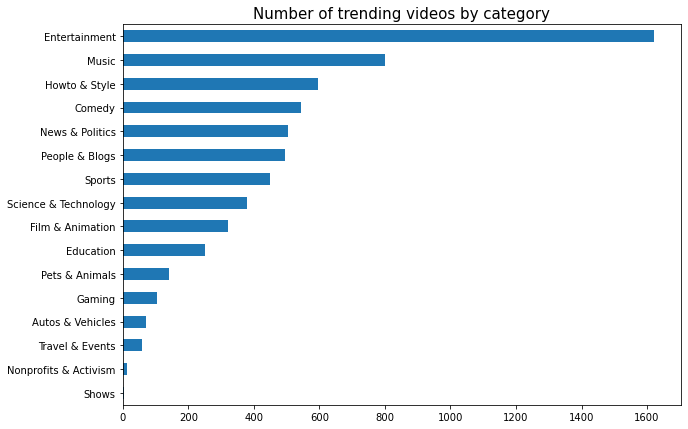

In [35]:
# Jackie's Code

## VISUALIZATION 3: How many videos have gone trending per Category? (Bar Chart)
last_df['Category'].value_counts().sort_values().plot(kind='barh', figsize=(10,7))
plt.title("Number of trending videos by category", size=15)
plt.show()

In [36]:
## Jackie's Code

## VISUALIZATION 1: How do views and dis/likes correlate? (Linear Regression)
# Define function for creating linear regression and scatter plot
import scipy.stats as st

# Define linear regression line
def linear_regression(x,y):
    print(f"The r-squared is : {round(st.pearsonr(x, y)[0],2)}")
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    regress_values = x * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x, y)
    plt.plot(x,regress_values,"r-")
    return line_eq

# Define a function for annotating
def annotate(line_eq, a,b):
    plt.annotate(line_eq,(0,0),fontsize=15,color="red")

The r-squared is : 0.69


Text(0, 0.5, 'Likes')

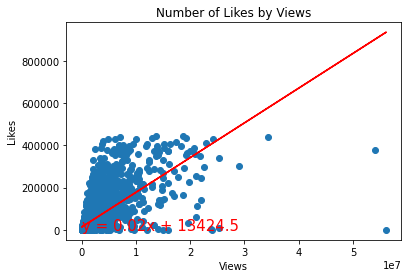

In [37]:
## Jackie's Code

## VISUALIZATION 1: How do views and likes correlate? (Linear Regression)
# Filter outliers in data
def reject_outliers(last_df):
    u = np.mean(last_df.likes)
    s = np.std(last_df.likes)
    likes_filtered = last_df[(last_df.likes > u-2*s) & (last_df.likes < u+2*s)]
    return likes_filtered 

likes_filtered = reject_outliers(last_df)
x = likes_filtered['views'] 
y = likes_filtered['likes']

equation = linear_regression(x, y)
annotate(equation, 0, 0)
plt.title("Number of Likes by Views")
plt.xlabel("Views")
plt.ylabel("Likes")

The r-squared is : 0.69


Text(0, 0.5, 'Dislikes')

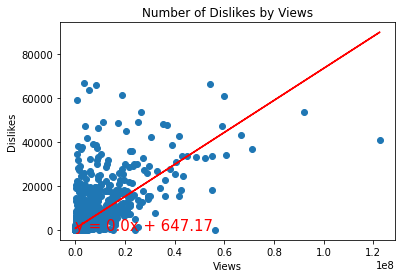

In [38]:
## Jackie's Code

## VISUALIZATION 1: How do views and dislikes correlate? (Linear Regression)
# Filter outliers in data
def reject_outliers(last_df):    
    u = np.mean(last_df.dislikes)
    s = np.std(last_df.dislikes)
    dislikes_filtered = last_df[(last_df.dislikes > u-2*s) & (last_df.dislikes < u+2*s)]
    return dislikes_filtered

dislikes_filtered = reject_outliers(last_df)
x = dislikes_filtered['views'] 
y = dislikes_filtered['dislikes']

equation = linear_regression(x, y)
annotate(equation, 0, 0)
plt.title("Number of Dislikes by Views")
plt.xlabel("Views")
plt.ylabel("Dislikes")

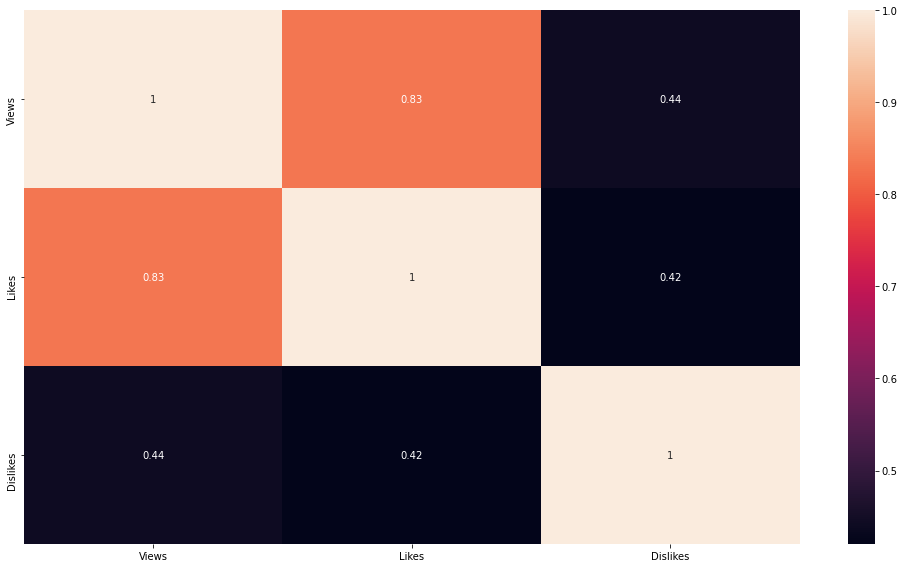

In [40]:
## Jackie's Code

## VISUALIZATION 1: How do views and dislikes correlate? (correlation matrix)
heatmap_columns = ['views', 'likes', 'dislikes']
h_labels = ['Views', 'Likes', 'Dislikes']
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(last_df[heatmap_columns].corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels)

plt.tight_layout()

In [ ]:
# Brian's Code

In [ ]:
# Generate a bar plot showing the top 20 youtube channels with most trending videos.

# groupby video_id using count and channel_title
vids_per_title_df = last_df[["video_id", "channel_title"]]
# vids_per_title_df.head()

vids_per_title_df = vids_per_title_df.groupby("channel_title").count()
# len(vids_per_title_df)
# vids_per_title_df.head()

vids_per_title_df = vids_per_title_df.sort_values(by = 'video_id', ascending = False)
# vids_per_title_df.head()

# plot a bar chart
# vids_per_title_df.head(20).plot(kind="bar", figsize=(12,8), color = "b", legend=False)
vids_per_title_df.head(20).plot(kind="bar", figsize=(12,8), color = [plt.cm.Paired(np.arange(len(vids_per_title_df)))], legend=False)

# title
plt.title("Top Twenty YouTube Channels With Most Trending Videos")
plt.xticks(rotation=45, horizontalalignment="right")
plt.xlabel("YouTube Channels")
plt.ylabel("Number of Trending Videos")

plt.show()
# plt.tight_layout()

In [ ]:
## Brian's code